## Imports

In [1]:
import numpy as np
import sgf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## Classes

In [2]:
class SGFAnalyzer:
    """Class for loading and analyzing SGF data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.sgf_collection = self._load_sgf_file()
        self.insights = self._extract_game_insights()

    def _load_sgf_file(self):
        with open(self.file_path, 'r') as sgf_file:
            sgf_content = sgf_file.read()
        return sgf.parse(sgf_content)
    
    def _extract_game_insights(self):
        """Extracts game insights for analysis."""
        insights = {
            'total_games': len(self.sgf_collection),
            'black_wins': 0,
            'white_wins': 0,
            'total_moves_per_game': [],
            'board_size_distribution': [],
            'move_coordinates': {'B': [], 'W': []},
            'win_by_board_size': defaultdict(lambda: {'B': 0, 'W': 0})
        }

        for game in self.sgf_collection:
            root_node = game.root
            board_size = int(root_node.properties.get('SZ', ['Unknown'])[0])
            insights['board_size_distribution'].append(board_size)
            result = root_node.properties.get('RE', ['Unknown'])[0]
            
            if 'B+' in result:
                insights['black_wins'] += 1
                insights['win_by_board_size'][board_size]['B'] += 1
            elif 'W+' in result:
                insights['white_wins'] += 1
                insights['win_by_board_size'][board_size]['W'] += 1

            move_count, move_coords = self._extract_moves(root_node)
            insights['total_moves_per_game'].append(move_count)
            insights['move_coordinates']['B'].extend(move_coords['B'])
            insights['move_coordinates']['W'].extend(move_coords['W'])

        return insights

    def _extract_moves(self, root_node):
        """Extracts moves from a game node and organizes them by player."""
        move_count = 0
        move_coords = {'B': [], 'W': []}
        
        node = root_node
        while node is not None:
            move = node.properties.get('B') or node.properties.get('W')
            if move:
                player = 'B' if 'B' in node.properties else 'W'
                move_coords[player].append(move[0])
                move_count += 1
            node = node.next
        return move_count, move_coords

    def get_insights(self):
        """Returns the extracted game insights."""
        return self.insights

In [3]:
class NPZAnalyzer:
    """Class for loading and analyzing NPZ data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = self._load_npz_file()

    def _load_npz_file(self):
        return np.load(self.file_path)

    def get_insights(self):
        """Extracts and returns shape and statistical insights for NPZ data."""
        insights = {
            'board_states': self.data['binaryInputNCHWPacked'],
            'move_probabilities': self.data['policyTargetsNCMove'],
            'game_values': self.data['valueTargetsNCHW']
        }
        return insights

In [4]:
class Visualizer:
    """Class providing methods for visualizing and displaying insights."""

    @staticmethod
    def display_sgf_insights(insights):
        total_games = insights['total_games']
        print("\n===== Game Insights =====")
        print(f"Total games: {total_games}")
        print(f"Black wins: {insights['black_wins']} ({(insights['black_wins'] / total_games) * 100:.2f}%)")
        print(f"White wins: {insights['white_wins']} ({(insights['white_wins'] / total_games) * 100:.2f}%)")
        print(f"Average moves per game: {np.mean(insights['total_moves_per_game']):.2f}")
        print(f"Max moves in a game: {np.max(insights['total_moves_per_game'])}")
        print(f"Min moves in a game: {np.min(insights['total_moves_per_game'])}")

        Visualizer.plot_board_size_distribution(insights['board_size_distribution'])
        Visualizer.plot_win_rates_by_board_size(insights['win_by_board_size'])
        Visualizer.plot_move_heatmap(insights['move_coordinates'], max(insights['board_size_distribution']))

    @staticmethod
    def display_npz_insights(insights):
        print("NPZ Data Analysis:")
        print(f"Board states shape: {insights['board_states'].shape}")
        print(f"Move probabilities shape: {insights['move_probabilities'].shape}")
        print(f"Game values shape: {insights['game_values'].shape}")
        
        Visualizer.plot_probability_distribution(insights['move_probabilities'])
        Visualizer.plot_game_value_distribution(insights['game_values'])

    @staticmethod
    def plot_board_size_distribution(board_size_distribution):
        plt.figure(figsize=(8, 6))
        sns.histplot(board_size_distribution, kde=True, bins=range(min(board_size_distribution), max(board_size_distribution)+1))
        plt.title('Distribution of Board Sizes')
        plt.xlabel('Board Size')
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def plot_win_rates_by_board_size(win_by_board_size):
        board_sizes = list(win_by_board_size.keys())
        black_win_rates = [win_by_board_size[bs]['B'] / (win_by_board_size[bs]['B'] + win_by_board_size[bs]['W']) * 100 for bs in board_sizes]
        white_win_rates = [100 - bw for bw in black_win_rates]

        plt.figure(figsize=(10, 6))
        plt.plot(board_sizes, black_win_rates, label='Black Win Rate (%)', marker='o')
        plt.plot(board_sizes, white_win_rates, label='White Win Rate (%)', marker='o')
        plt.title('Win Rates by Board Size')
        plt.xlabel('Board Size')
        plt.ylabel('Win Rate (%)')
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def plot_move_heatmap(move_coordinates, board_size):
        board_black = np.zeros((board_size, board_size))
        board_white = np.zeros((board_size, board_size))
        
        for move in move_coordinates['B']:
            x, y = ord(move[0]) - ord('a'), ord(move[1]) - ord('a')
            board_black[x, y] += 1
        for move in move_coordinates['W']:
            x, y = ord(move[0]) - ord('a'), ord(move[1]) - ord('a')
            board_white[x, y] += 1
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.heatmap(board_black, cmap='Blues', cbar=True, annot=True, fmt='g', linewidths=0.5)
        plt.title('Heatmap of Black Moves')
        plt.subplot(1, 2, 2)
        sns.heatmap(board_white, cmap='Reds', cbar=True, annot=True, fmt='g', linewidths=0.5)
        plt.title('Heatmap of White Moves')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_probability_distribution(move_probabilities):
        plt.figure(figsize=(8, 6))
        sns.histplot(move_probabilities.flatten(), kde=True, bins=50)
        plt.title('Distribution of Move Probabilities')
        plt.xlabel('Probability')
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def plot_game_value_distribution(game_values):
        plt.figure(figsize=(8, 6))
        sns.histplot(game_values.flatten(), kde=True, bins=50)
        plt.title('Distribution of Game Value Predictions')
        plt.xlabel('Value Prediction')
        plt.ylabel('Frequency')
        plt.show()

## Run


===== Game Insights =====
Total games: 1000
Black wins: 598 (59.80%)
White wins: 402 (40.20%)
Average moves per game: 70.99
Max moves in a game: 151
Min moves in a game: 5


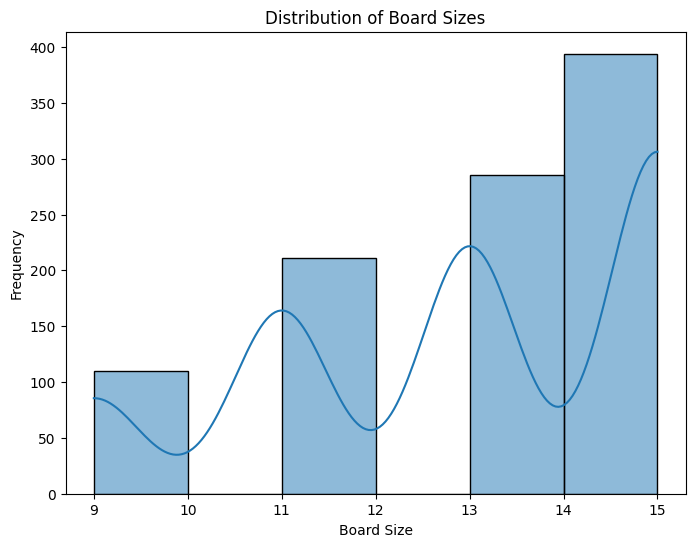

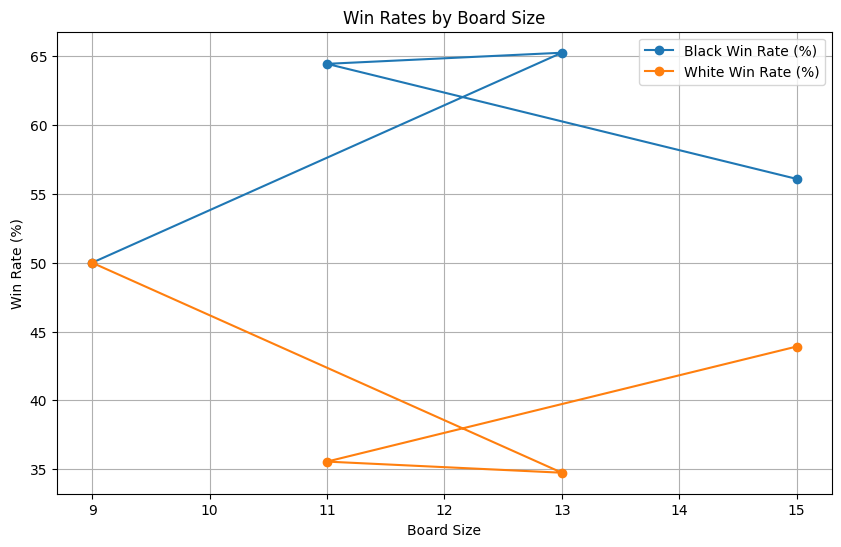

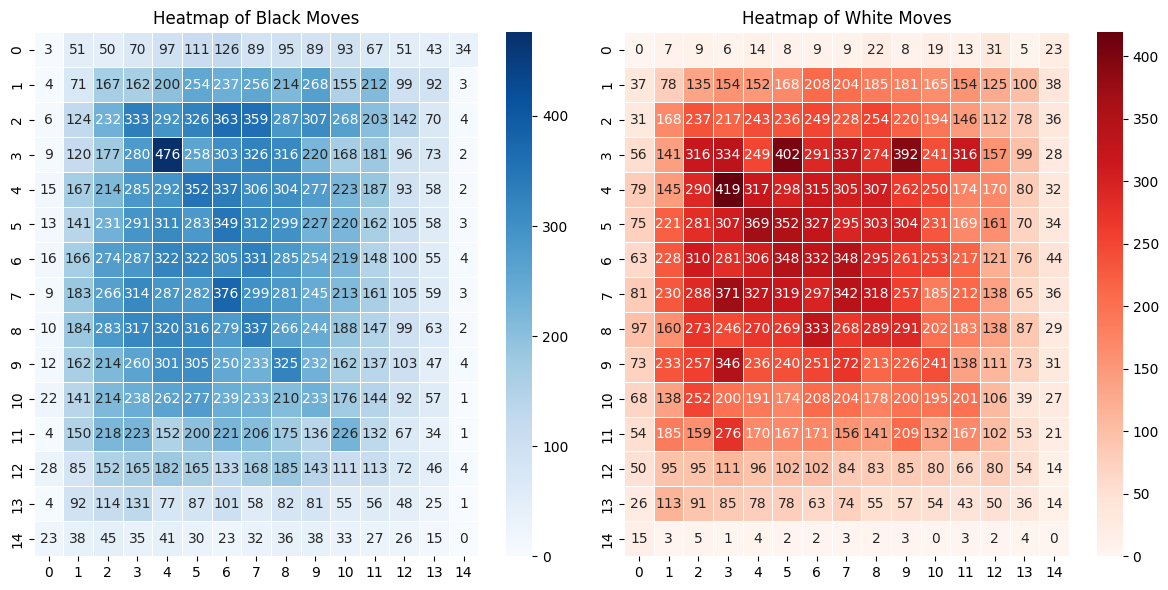

In [5]:
sgf_analyzer = SGFAnalyzer("data/kata/3410D33F8D987D6B.sgfs")
Visualizer.display_sgf_insights(sgf_analyzer.get_insights())

NPZ Data Analysis:
Board states shape: (12943, 22, 29)
Move probabilities shape: (12943, 2, 226)
Game values shape: (12943, 5, 15, 15)


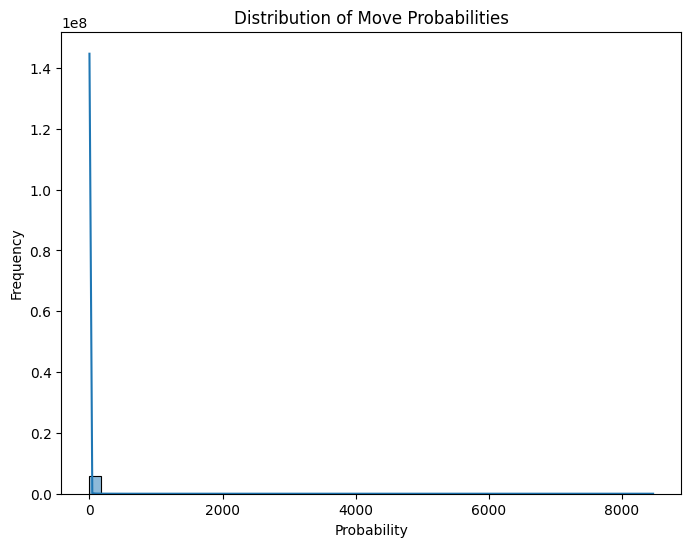

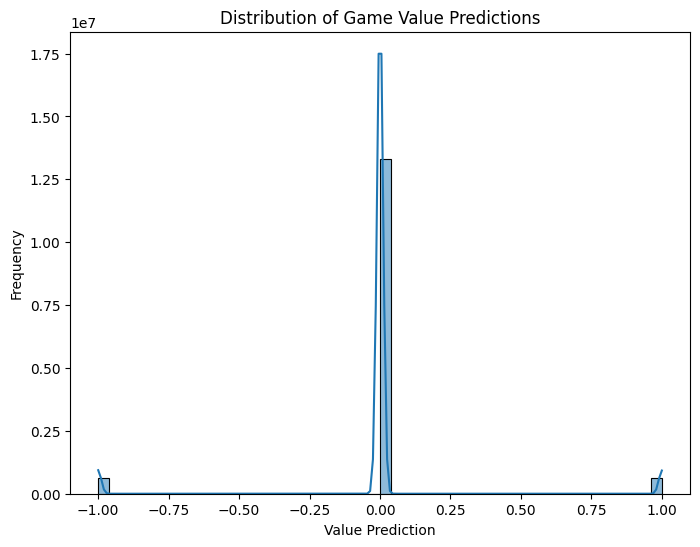

In [6]:
npz_analyzer = NPZAnalyzer("data/kata/0163D9F0F6642BD3.npz")
Visualizer.display_npz_insights(npz_analyzer.get_insights())